In [113]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [81]:
def cargar_datos(filename):
    df = pd.read_csv(filename, sep=',', error_bad_lines=False, header = None)
    df.drop([0,1,2,4], axis = 1, inplace = True)

    df[3] = df[3].astype(str)
    
    lista_inter_autores = [((x.iat[0]).lstrip()).split(" & ") for index, x in df.iterrows()]
    lista_inter_autores

    grafo = nx.Graph()
    for autores in lista_inter_autores:
        if len(autores) == 1:
            grafo.add_node(autores[0])
        else:
            vecinos = lista_pares(autores)
            grafo.add_edges_from(vecinos)

    return grafo

def lista_pares(autores):
    lista = []
    for i in range(len(autores) -1):
        for j in range(i+ 1, len(autores)):
            aux = (autores[i], autores[j])
            lista.append(aux)
    return lista


grafo = cargar_datos('data.csv')


b'Skipping line 14: expected 5 fields, saw 6\nSkipping line 49: expected 5 fields, saw 6\nSkipping line 55: expected 5 fields, saw 6\nSkipping line 74: expected 5 fields, saw 6\nSkipping line 76: expected 5 fields, saw 7\nSkipping line 82: expected 5 fields, saw 7\nSkipping line 84: expected 5 fields, saw 6\nSkipping line 98: expected 5 fields, saw 6\nSkipping line 142: expected 5 fields, saw 6\nSkipping line 144: expected 5 fields, saw 6\nSkipping line 159: expected 5 fields, saw 6\nSkipping line 177: expected 5 fields, saw 6\nSkipping line 221: expected 5 fields, saw 6\nSkipping line 224: expected 5 fields, saw 6\nSkipping line 287: expected 5 fields, saw 6\nSkipping line 322: expected 5 fields, saw 6\nSkipping line 324: expected 5 fields, saw 6\nSkipping line 325: expected 5 fields, saw 6\nSkipping line 326: expected 5 fields, saw 6\nSkipping line 354: expected 5 fields, saw 6\nSkipping line 386: expected 5 fields, saw 12\nSkipping line 398: expected 5 fields, saw 7\nSkipping line 3

In [130]:
histo = nx.degree_histogram(grafo)

# 2) Distribución de Grado
## Escala lineal

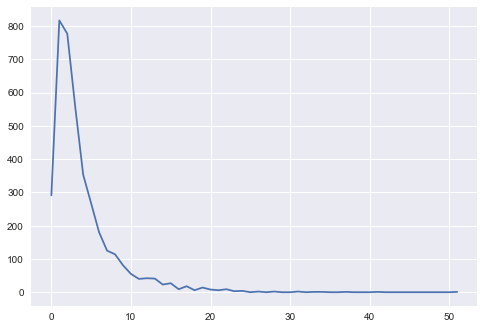

In [127]:
plt.plot(histo)
plt.show()

## Escala semilogarítmica eje y.

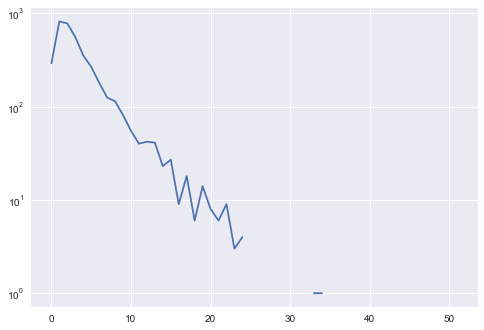

In [128]:
plt.semilogy(histo)
plt.show()

## Escala logarítmica, eje x e y.

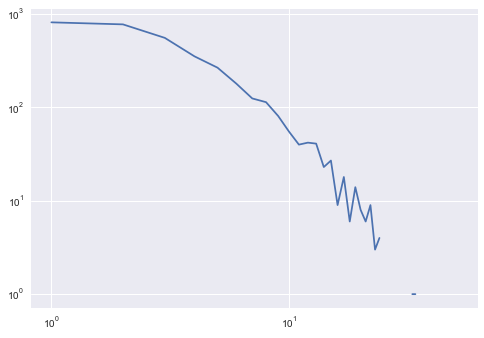

In [129]:
plt.loglog(histo)
plt.show()